<font color='blue'> **part0_intro_to_eva_and_dsi** </font>  <br>
**| EVA** =  Ensemble Variance Analysis  **| DSI** = Data Space Inversion **| FOSM** First Order Second Moment” | **Surrogate Model**

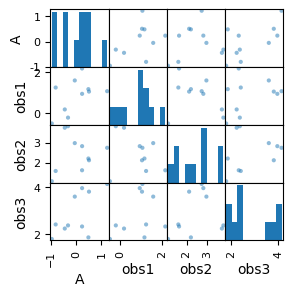

In [1]:
import pandas as pd  ; import numpy as np ; from matplotlib import pyplot as plt ; import seaborn as sns; from scipy.optimize import minimize
from IPython.display import display, HTML

mean = [0, 1, 2, 3]  ; nreal = 10
true_cov = [[1, 0.8, 0.5, 0.5],  [0.8, 1, 0.3, 0.3],  [0.5, 0.3, 1, .2], [0.5, 0.3,.2,1]]                      ; np.random.seed(42)
Data = pd.DataFrame(np.random.multivariate_normal(mean, true_cov, nreal),columns=["A","obs1","obs2","obs3"])
_ = pd.plotting.scatter_matrix(Data, figsize=(3,3))                                  # Fake A observation ensemble 
#fig = plt.figure(figsize=(4, 2)) ; A = np.random.normal(Data['obs1'])    ; plt.hist (A, color='green' , alpha=.3) ; noiseflag = 'No'

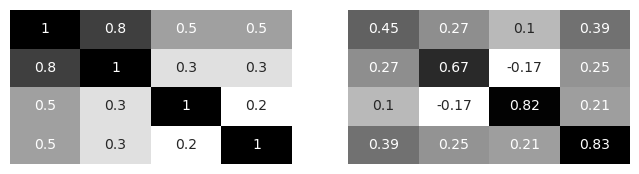

In [2]:
Cd = Data.cov()                           
fig = plt.figure(figsize=(8, 2))  
ax = fig.add_subplot(121) ; sns.heatmap(true_cov ,annot=True, cmap='binary', cbar=False) ;plt.axis('off') 
ax = fig.add_subplot(122) ; sns.heatmap(Cd       ,annot=True, cmap='binary', cbar=False) ;plt.axis('off') ; plt.show()

In [3]:
deltaD  = Data.T.apply(lambda d:(d-d.mean())/np.sqrt(Data.shape[0]-1),axis=1)                                    # ; deltaD  = Data.T 
U, Sigma, Vt = np.linalg.svd(deltaD, full_matrices=False)  ; print ('USV_shapes:',U.shape,Sigma.shape,Vt.shape)    ; deltaD.head(10)

USV_shapes: (4, 4) (4,) (4, 10)


,0,1,2,3,4,5,6,7,8,9
A,-0.273822,0.075193,0.166860,-0.110550,0.407099,-0.325182,0.075781,-0.021043,0.159030,-0.153366
obs1,0.124910,0.432239,0.059494,-0.360164,0.065883,-0.454674,0.023215,0.238918,0.098742,-0.228563
obs2,-0.291543,-0.279774,-0.115676,0.443336,0.089026,-0.459621,0.116098,0.166154,-0.086742,0.418742
obs3,-0.145228,-0.173883,0.317700,-0.158761,0.426137,-0.350205,0.367479,0.247777,-0.328100,-0.202915


Sigma:


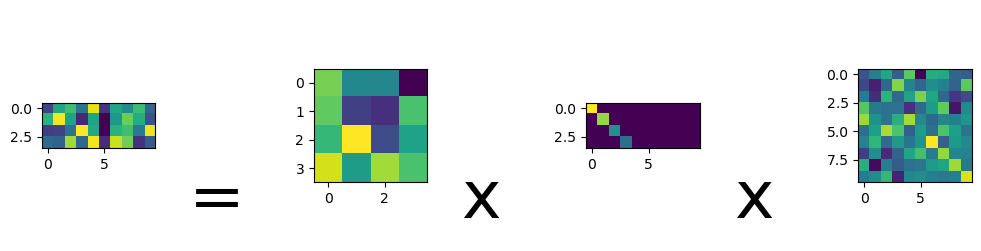

In [4]:
def svd(deltaD):     
    U, s, Vt = np.linalg.svd(deltaD)   ; S = np.zeros(deltaD.shape)  ; np.fill_diagonal(S, s) ;  return np.round(U, 3), np.round(S, 3), np.round(Vt.T, 3)
def visualize_svd(fig_height = 6):
    U, S, V = svd(deltaD)
    fig, axs = plt.subplots(1, 7, figsize=(12, fig_height))
    plt.sca(axs[0]) ; plt.imshow(deltaD)     ;plt.sca(axs[1]) ;plt.text(.1,.1,'=',fontsize=48) ;plt.axis('off') 
    plt.sca(axs[2]) ; plt.imshow(U)          ;plt.sca(axs[3]) ;plt.text(.1,.1,'x',fontsize=48) ;plt.axis('off')
    plt.sca(axs[4]) ; plt.imshow(S)          ;plt.sca(axs[5]) ;plt.text(.1,.1,'x',fontsize=48) ;plt.axis('off')
    plt.sca(axs[6]) ; plt.imshow(V.T)
visualize_svd(fig_height=3)                  # PLOT cautiously (RAM memory issue) ~ nreal max = 100
S   = np.zeros(deltaD.shape)      ; np.fill_diagonal(S, Sigma) ; print('Sigma:')

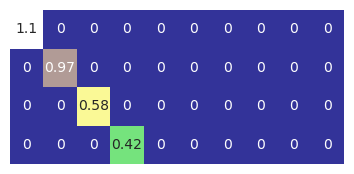

In [5]:
fig = plt.figure(figsize=(25, 2)) ; ax = fig.add_subplot(154)  ; sns.heatmap(np.round(S,3),annot=True,cmap='terrain',cbar=False) ;plt.axis('off') ;plt.show()

In [6]:
Data_mean = Data.mean()   ; D9 = Data.iloc[-1]  ; Cd_sqrt = np.dot (U ,np.diag(Sigma))  ; X = np.zeros_like(Sigma)   # X = superPAR = [0,0,0,0]
def FORWARD(X):             return Data_mean.values + np.dot(Cd_sqrt, X)                                             # pretend to read Data_mean = (Cd_sqrt * X)
Data2 = FORWARD(X) 
def obj_f_PHI(x):                 return np.sum((FORWARD(x)[1:] - D9[1:])**2)                                              # Objective function

S_zero_PAR = np.zeros_like(Sigma)   ; MOD_in_zero = FORWARD(S_zero_PAR)     ; RES = minimize(obj_f_PHI, S_zero_PAR,tol=1e-8)    ; resX = FORWARD (RES.x) 
print('S_zero_PAR=',S_zero_PAR)     ; print('MOD_in_zero=',MOD_in_zero)     ; print('resX=',resX)

S_zero_PAR= [0. 0. 0. 0.]
MOD_in_zero= [0.0090173  0.87341287 2.47211076 2.85827438]
resX= [-0.28501073  0.18772336  3.72833689  2.24952846]


In [7]:
D9[1:]     = Data.iloc[-1][1:]     ; print('D9:' ,np.around(D9[1:]).tolist())            ; print(MOD_in_zero[1:])  ; print(resX[1:])
D9.iloc[0] = Data.iloc[-1].iloc[0] ; print('D9:' ,np.around(D9.iloc[0]).tolist())        ; print(MOD_in_zero[0])   ; print(resX[0])

D9: [0.0, 4.0, 2.0]
[0.87341287 2.47211076 2.85827438]
[0.18772336 3.72833689 2.24952846]
D9: -0.0
0.00901730335653798
-0.28501072949581396


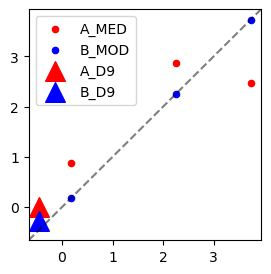

In [8]:
fig,ax = plt.subplots(1,1,figsize=(3,3))
ax.scatter(D9[1:]     ,MOD_in_zero[1:],marker='o',s=20,c="red",label="A_MED") ;ax.scatter(D9[1:]    ,resX[1:],marker='o',s=20,c="blue",label="B_MOD")
ax.scatter(D9.iloc[0] ,MOD_in_zero[0],marker='^',s=200,c="red",label="A_D9")  ;ax.scatter(D9.iloc[0],resX[0] ,marker='^',s=200,c="b"  ,label="B_D9")

mn=min(ax.get_ylim()[0],ax.get_xlim()[0])  ; mx=max(ax.get_ylim()[1],ax.get_xlim()[1]) ; ax.plot([mn,mx],[mn,mx],"k--",alpha=0.5)  
ax.set_xlim(mn,mx) ; ax.set_ylim(mn,mx)    ; ax.legend(loc="upper left") ; noiseflag = 'No'

In [9]:
num_reals=nreal                                                       ; pS = np.random.standard_normal((num_reals,Sigma.shape[0]))  
Prior=pd.DataFrame([FORWARD(vec) for vec in pS],columns=Data.columns) ; Prior["s0_Forward"]=Prior.apply(lambda x:((x.values[1:]-D9[1:])**2).sum(),axis=1)     

nobs=Data.shape[1]-1  ;POST=Prior.loc[Prior["s0_Forward"] <=nobs,:]    ; Prior=Prior.rename({'A':'B'},axis=1) 
POSTb=POST.rename({'s0_Forward':'s1_Calibrated'},axis=1)               ; POSTc=POSTb.rename({'A':'C'},axis=1)      

ht=f"<table><tr><td>  {Data.to_html()} </td><td> {Prior.to_html()} </td><td> {POSTc.to_html()} </td></tr></table>"  ; display(HTML(ht))

,A,obs1,obs2,obs3
0,-0.812449,1.248144,1.597482,2.422590
1,0.234596,2.170130,1.632788,2.336625
2,0.509598,1.051895,2.125083,3.811373
3,-0.322632,-0.207080,3.802120,2.381991
4,1.230315,1.071061,2.739189,4.136684
5,-0.966530,-0.490609,1.093247,1.807660
6,0.236360,0.943059,2.820405,3.960713
7,-0.054113,1.590166,2.970572,3.601605
8,0.486108,1.169639,2.211885,1.873975
9,-0.451081,0.187723,3.728337,2.249528


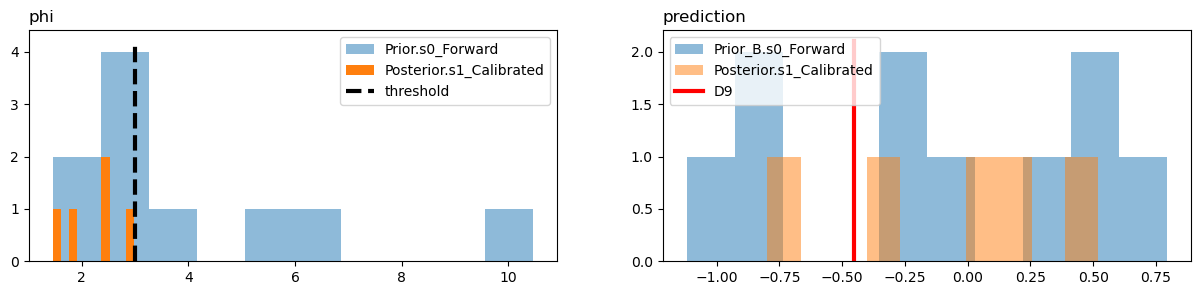

In [10]:
fig,axes = plt.subplots(1,2,figsize=(15,3))
ax=axes[0]        ; ax.hist(Prior["s0_Forward"],alpha=0.5,label="Prior.s0_Forward")  ; ax.hist(POSTb.s1_Calibrated ,label="Posterior.s1_Calibrated")
ylim=ax.get_ylim(); ax.plot([nobs,nobs],ylim,"k--",lw=3,label="threshold")           ; ax.legend(loc="upper right")  ; ax.set_title("phi",loc="left")

ax=axes[1]        ; ax.hist(Prior.B,alpha=0.5,label="Prior_B.s0_Forward")      ; ax.hist(POSTc.C ,alpha=0.5,label="Posterior.s1_Calibrated")
ylim=ax.get_ylim(); ax.plot([D9.iloc[0],D9.iloc[0]],ylim,"r",lw=3,label="D9")  ; ax.legend(loc="upper left")  ; ax.set_title("prediction",loc="left") ;noiseflag='No'